In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf

from tensorflow.keras.preprocessing import image_dataset_from_directory

In [2]:
physical_devices = tf.config.list_physical_devices('GPU')
try:
  tf.config.experimental.set_memory_growth(physical_devices[0], True)
except:
  # Invalid device or cannot modify virtual devices once initialized.
  pass

In [3]:
train_dir = 'cats_and_dogs_filtered/train'
validation_dir = 'cats_and_dogs_filtered/validation'

BATCH_SIZE = 32
IMG_SIZE = (160, 160)


In [24]:

train_dataset = image_dataset_from_directory(train_dir,
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE)


Found 2000 files belonging to 2 classes.


In [25]:
class_names = train_dataset.class_names

In [5]:
validation_dataset = image_dataset_from_directory(validation_dir,
                                                  shuffle=True,
                                                  batch_size=BATCH_SIZE,
                                                  image_size=IMG_SIZE)


Found 1000 files belonging to 2 classes.


In [6]:
val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batches // 5)
validation_dataset = validation_dataset.skip(val_batches // 5)


In [23]:
print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))


Number of validation batches: 26
Number of test batches: 6


AttributeError: 'PrefetchDataset' object has no attribute 'class_names'

In [8]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)


In [9]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
  tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
])


In [10]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

In [11]:
# Create the base model from the pre-trained model MobileNet V2
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')


In [12]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)


(32, 5, 5, 1280)


In [13]:
base_model.trainable = False


In [17]:
base_model.summary()


Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 80, 80, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 80, 80, 32)   128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 80, 80, 32)   0           bn_Conv1[0][0]                   
_______________________________________________________________________________

In [14]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)


(32, 1280)


In [15]:
prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)


(32, 1)


In [16]:
inputs = tf.keras.Input(shape=(160, 160, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)


In [17]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])


In [18]:
initial_epochs = 10
loss0, accuracy0 = model.evaluate(validation_dataset)
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))



26/26 [==============================] - 3s 57ms/step - loss: 0.9702 - accuracy: 0.3950
initial loss: 0.97
initial accuracy: 0.39


In [19]:
history = model.fit(train_dataset,
                    epochs=39,
                    validation_data=validation_dataset)


Epoch 1/39
63/63 [==============================] - 6s 74ms/step - loss: 0.8674 - accuracy: 0.4685 - val_loss: 0.6707 - val_accuracy: 0.5879
Epoch 2/39
63/63 [==============================] - 4s 65ms/step - loss: 0.6661 - accuracy: 0.6140 - val_loss: 0.4816 - val_accuracy: 0.7141
Epoch 3/39
63/63 [==============================] - 4s 65ms/step - loss: 0.5122 - accuracy: 0.7205 - val_loss: 0.3742 - val_accuracy: 0.7995
Epoch 4/39
63/63 [==============================] - 4s 64ms/step - loss: 0.4235 - accuracy: 0.7935 - val_loss: 0.2969 - val_accuracy: 0.8577
Epoch 5/39
63/63 [==============================] - 4s 65ms/step - loss: 0.3675 - accuracy: 0.8315 - val_loss: 0.2539 - val_accuracy: 0.8960
Epoch 6/39
63/63 [==============================] - 5s 66ms/step - loss: 0.3116 - accuracy: 0.8585 - val_loss: 0.2200 - val_accuracy: 0.9084
Epoch 7/39
63/63 [==============================] - 4s 65ms/step - loss: 0.2889 - accuracy: 0.8685 - val_loss: 0.1908 - val_accuracy: 0.9270
Epoch 8/39
63

In [24]:
from numba import cuda 
device = cuda.get_current_device()
device.reset()

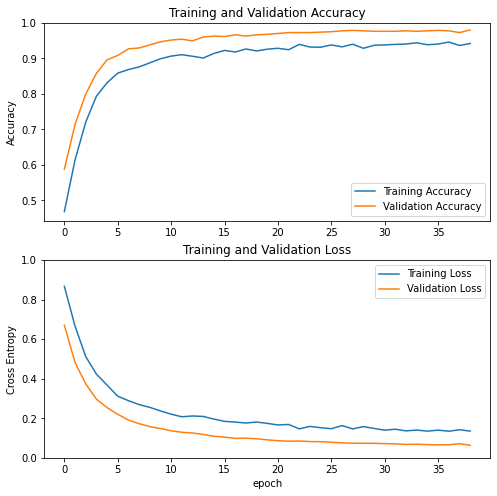

In [20]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()


Predictions:
 [1 1 0 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 0 0 1 1 1 1 0 0 1 1 0 1 1]
Labels:
 [1 1 0 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 0 0 1 1 1 0 0 0 0 1 0 1 1]


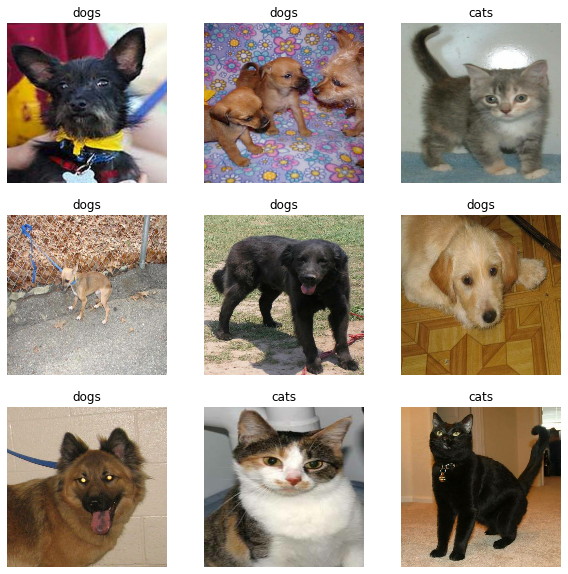

In [26]:
#Retrieve a batch of images from the test set
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()

# Apply a sigmoid since our model returns logits
predictions = tf.nn.sigmoid(predictions)
predictions = tf.where(predictions < 0.5, 0, 1)

print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(class_names[predictions[i]])
  plt.axis("off")
